**Imports**

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import warnings
from sklearn.model_selection import TimeSeriesSplit
warnings.simplefilter(action='ignore', category=FutureWarning)

**Helper functions**

In [2]:
def custom_loss_scorer(estimator,X,y):
    weight_array = np.where(X.IsHoliday==True,5,1)
    preds = estimator.predict(X)
    error = np.mean(weight_array*np.abs(y-preds))
    
    return -(error)

In [3]:
def create_date_features(df):
    
    df['quarter'] = df['Date'].dt.quarter
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    #df['dayofyear'] = df['Date'].dt.dayofyear
    df['weekofyear'] = df['Date'].dt.weekofyear
    df['day'] = df['Date'].dt.day
    df['days'] = (df.month-1) * 30 + df.day
    df['tDays'] = (df.year-2010)*360 + df.days

    def week_of_month(dt):
        """ Returns the week of the month for the specified date.
        """

        first_day = dt.replace(day=1)

        dom = dt.day
        adjusted_dom = dom + first_day.weekday()

        return int(ceil(adjusted_dom/7.0))
    
    df['weekofmonth'] = df['Date'].apply(week_of_month)
    
    return df

In [4]:
def one_hot_encoding(train,test,cat_features):
    ohe = OneHotEncoder()
    
    ohe_train = ohe.fit_transform(train[cat_features]).toarray()
    ohe_train = pd.DataFrame(ohe_train,columns=ohe.get_feature_names())
    train.drop(cat_features,axis=1,inplace=True)
    train.reset_index(drop=True,inplace=True)
    train = pd.concat([train,ohe_train],axis=1)
    
    ohe_test = ohe.transform(test[cat_features]).toarray()
    ohe_test = pd.DataFrame(ohe_test,columns=ohe.get_feature_names())
    test.drop(cat_features,axis=1,inplace=True)
    test.reset_index(drop=True,inplace=True)
    test = pd.concat([test,ohe_test],axis=1)
    
    return (train,test)

In [5]:
def create_lag_features(train,test,lags):
    
    train['set']='Train'
    test['set']='Test'
    test['Weekly_Sales']=0
    
    one_df=pd.concat([train,test],ignore_index=True)
    
    lags = range(39, lags+1)

    df = one_df.assign(**{'Weekly_sales(t-{})'.format(t): one_df.groupby(['Store','Dept']).Weekly_Sales.shift(t) for t in lags})
    
    train_set = df[df.set=='Train']
    test_set = df[df.set=='Test']

    
    return train_set,test_set

In [6]:
def create_other_features(df):
    df['IsHoliday_bin']=np.where(df.IsHoliday,1,0)
    
    #type_dict = {'A':1,'B':2,'C':3}
    #df['Type_num']=df.Type.map(type_dict)
    
    return df

In [7]:
def imputing(train,test,num_features):
    imputer = SimpleImputer(strategy='constant',fill_value=0)
    

    imp_train = pd.DataFrame(imputer.fit_transform(train[num_features]),columns=num_features)
    train[num_features] = imp_train
    
    test.reset_index(drop=True,inplace=True)
    imp_test = pd.DataFrame(imputer.transform(test[num_features]),columns=num_features)
    test[num_features] = imp_test
    
    return train,test

In [8]:
def log_error(preds,org,weights):
    org_preds = np.exp(preds)-4990
    error = np.mean(weights*np.abs(org-org_preds))
    return error

In [9]:
def custom_log_loss_scorer(estimator,X,y):
    weight_array = np.where(X.IsHoliday_num==1,5,1)
    log_preds = estimator.predict(X)
    org_preds = np.exp(log_preds)-4990
    org_y = np.exp(y)-4990
    error = np.mean(weight_array*np.abs(org_y-org_preds))
    
    return -(error)

In [10]:
def error(preds,org,weights):
    error = np.mean(weights*np.abs(preds-org))
    return error

### Data Imports, Cleaning and Feature Generation

In [11]:
features = pd.read_csv('walmart-recruiting-store-sales-forecasting/features.csv',parse_dates=[1])
stores = pd.read_csv('walmart-recruiting-store-sales-forecasting/stores.csv')
test = pd.read_csv('walmart-recruiting-store-sales-forecasting/test.csv',parse_dates=[2])
train = pd.read_csv('walmart-recruiting-store-sales-forecasting/train.csv',parse_dates=[2])
submission = pd.read_csv('walmart-recruiting-store-sales-forecasting/sampleSubmission.csv')

In [12]:
train_data = pd.merge(left=pd.merge(left=train,right=stores,how='left'),right=features,how='left',on=['Store','Date','IsHoliday'])
test_data = pd.merge(left = pd.merge(left=test,right=stores,how='left'),right=features,how='left',on = ['Store','Date','IsHoliday'])

In [13]:
train_data = create_date_features(train_data)
test_data = create_date_features(test_data)

In [14]:
train_data,test_data = one_hot_encoding(train_data,test_data,['Type'])

In [15]:
train_data,test_data = create_lag_features(train_data,test_data,52)

In [16]:
train_data = create_other_features(train_data)
test_data = create_other_features(test_data)

In [17]:
num_features = list(train_data.columns[np.isin(train_data.dtypes,['int32','int64','float64'])])
train_data,test_data = imputing(train_data,test_data,num_features)

In [18]:
train_data['log_sales'] = np.log(4990+train_data.Weekly_Sales)

In [19]:
train_data['Dept'] = train_data['Dept'].map(int)
train_data['Store'] = train_data['Store'].map(int)

### Models Cross Validation

In [20]:
train_rf_model = True
tscv = TimeSeriesSplit()
cv_data = dict()
fold=0
for train_index, test_index in tscv.split(train_data.Date.unique()):
    train_dates = train_data.Date.unique()[train_index]
    test_dates = train_data.Date.unique()[test_index]
    train_data_cv = train_data.loc[train_data.Date.isin(train_dates)]
    test_data_cv = train_data.loc[train_data.Date.isin(test_dates)]
    
    print('Fold:',fold)

    features_list = ['Size','x0_A','x0_B','x0_C','year','month','day','days','IsHoliday_bin','tDays',
                     'Weekly_sales(t-47)',
                     'Weekly_sales(t-48)',
                     'Weekly_sales(t-49)',
                    'Weekly_sales(t-50)', 
                     'Weekly_sales(t-51)', 
                     'Weekly_sales(t-52)']

    train_stores = train_data_cv.Store.unique()
    test_stores = test_data_cv.Store.unique()

    detailed_data = dict()
    print("Store:")
    for test_store in test_stores:

        
        train_depts = train_data_cv.loc[train_data_cv.Store==test_store].Dept.unique()
        test_depts = test_data_cv.loc[test_data_cv.Store==test_store].Dept.unique()

        print(str(test_store),end=' ')

        for test_dept in test_depts:

            #print(str(test_dept),end = " ")        
            less_than_10 = False

            train_store_dept_data = train_data_cv.loc[(train_data_cv.Store==test_store) & (train_data_cv.Dept == test_dept)]
            test_store_dept_data = test_data_cv[(test_data_cv.Store==test_store) & (test_data_cv.Dept==test_dept)]

            if (len(train_store_dept_data)<10):

                train_store_dept_data = train_data_cv.loc[train_data_cv.Dept == test_dept]
                test_store_dept_data = test_data_cv.loc[test_data_cv.Dept == test_dept]        
                less_than_10 = True

            X = train_store_dept_data[features_list]
            y = train_store_dept_data.log_sales
            weights = np.where(X.IsHoliday_bin==1,5,1)

            #XGB Model
            model_xgb = XGBRegressor(verbosity=0,njobs=-1, random_state=42)
            model_xgb.fit(X,y,sample_weight=weights)

            train_preds_xgb = model_xgb.predict(X)
            test_preds_xgb = model_xgb.predict(test_store_dept_data[features_list])

            if(train_rf_model):
            ##RF Model
                model_rf = RandomForestRegressor(n_estimators=500,n_jobs=-1,verbose=0,random_state=42)
                model_rf.fit(X,y)

                train_preds_rf = model_rf.predict(X)
                test_preds_rf = model_rf.predict(test_store_dept_data[features_list])

            if (less_than_10):

                if(len(train_data_cv.loc[(train_data_cv.Store==test_store) & (train_data_cv.Dept == test_dept)][features_list])>0):
                    train_preds_xgb = model_xgb.predict(train_data_cv.loc[(train_data_cv.Store==test_store) & (train_data_cv.Dept == test_dept)][features_list])
                    if(train_rf_model):
                        train_preds_rf = model_rf.predict(train_data_cv.loc[(train_data_cv.Store==test_store) & (train_data_cv.Dept == test_dept)][features_list])
                else:
                    train_preds_xgb = None
                    if(train_rf_model):
                        train_preds_rf = None

                if(len(test_data_cv.loc[(test_data_cv.Store==test_store) & (test_data_cv.Dept==test_dept)][features_list])>0):
                    test_preds_xgb = model_xgb.predict(test_data_cv[(test_data_cv.Store==test_store) & (test_data_cv.Dept==test_dept)][features_list])
                    if(train_rf_model):
                        test_preds_rf = model_rf.predict(test_data_cv[(test_data_cv.Store==test_store) & (test_data_cv.Dept==test_dept)][features_list])

                else:
                    test_preds_xgb = None
                    if(train_rf_model):
                        test_preds_rf = None

            current_data = dict()
            #current_data['train_X'] = X
            #current_data['train_y'] = y
            #current_data['test_X'] = test_store_dept_data[features_list]
            current_data['model_xgb'] = None
            current_data['model_rf'] = None  ##RF models take up a lot of memory. My system crashes if I store them.
            #current_data['less_data'] = less_than_10
            current_data['train_preds_xgb'] = train_preds_xgb
            current_data['test_preds_xgb'] = test_preds_xgb
            if(train_rf_model):
                current_data['train_preds_rf'] = train_preds_rf
                current_data['test_preds_rf'] = test_preds_rf

            detailed_data[str(test_store) + '_' + str(test_dept)] = current_data
    cv_data['Fold_' + str(fold)] = detailed_data
    fold+=1
    print("")

Fold: 0
Store:
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 
Fold: 1
Store:
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 
Fold: 2
Store:
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 


In [24]:
cv_preds = dict()

for i in range(fold):
    
    cv_preds['train_'+str(i)+'_xgb'] = [preds for dept_data in cv_data['Fold_'+str(i)].values() if dept_data['train_preds_xgb'] is not None for preds in dept_data['train_preds_xgb']]
    cv_preds['test_'+str(i)+'_xgb'] = [preds for dept_data in cv_data['Fold_'+str(i)].values() if dept_data['test_preds_xgb'] is not None for preds in dept_data['test_preds_xgb']]
    
    cv_preds['train_'+str(i)+'_rf'] = [preds for dept_data in cv_data['Fold_'+str(i)].values() if dept_data['train_preds_rf'] is not None for preds in dept_data['train_preds_rf']]
    cv_preds['test_'+str(i)+'_rf'] = [preds for dept_data in cv_data['Fold_'+str(i)].values() if dept_data['test_preds_rf'] is not None for preds in dept_data['test_preds_rf']]

In [25]:
fold = 0

xgb_train_errors = list()
xgb_test_errors = list()

rf_train_errors = list()
rf_test_errors = list()


for train_index, test_index in tscv.split(train_data.Date.unique()):
    train_dates = train_data.Date.unique()[train_index]
    test_dates = train_data.Date.unique()[test_index]
    train_data_cv = train_data.loc[train_data.Date.isin(train_dates)]
    test_data_cv = train_data.loc[train_data.Date.isin(test_dates)]
        
    redundant_pairs_mask = (~(train_data_cv.Store.map(str) +'-'+ train_data_cv.Dept.map(str)).isin(test_data_cv.Store.map(str) +'-'+ test_data_cv.Dept.map(str)))
    train_data_red = train_data_cv[~redundant_pairs_mask]
    
    xgb_train_error = log_error(cv_preds['train_'+str(fold)+'_xgb'],train_data_red.Weekly_Sales,weights=train_data_red.IsHoliday_bin)
    xgb_test_error = log_error(cv_preds['test_'+str(fold)+'_xgb'],test_data_cv.Weekly_Sales,weights=test_data_cv.IsHoliday_bin)
    
    rf_train_error = log_error(cv_preds['train_'+str(fold)+'_rf'],train_data_red.Weekly_Sales,weights=train_data_red.IsHoliday_bin)
    rf_test_error = log_error(cv_preds['test_'+str(fold)+'_rf'],test_data_cv.Weekly_Sales,weights=test_data_cv.IsHoliday_bin)
    
    xgb_train_errors.append(xgb_train_error)
    xgb_test_errors.append(xgb_test_error)
    
    rf_train_errors.append(rf_train_error)
    rf_test_errors.append(rf_test_error)
    
    fold+=1

In [26]:
print('XGB_Train_errors:                                          Mean_error:       Std_error')
print(xgb_train_errors,np.mean(xgb_train_errors),np.std(xgb_train_errors))
print('XGB_Test_errors:                                          Mean_error:       Std_error')
print(xgb_test_errors,np.mean(xgb_test_errors),np.std(xgb_test_errors))

print('RF_Train_errors:                                            Mean_error:       Std_error')
print(rf_train_errors,np.mean(rf_train_errors),np.std(rf_train_errors))
print('RF_Test_errors:                                             Mean_error:       Std_error')
print(rf_test_errors,np.mean(rf_test_errors),np.std(rf_test_errors))

XGB_Train_errors:                                          Mean_error:       Std_error
[3.290811150682096, 11.272404003876083, 15.85434554242053] 10.139186898992904 5.191257706195322
XGB_Test_errors:                                          Mean_error:       Std_error
[414.2752093873054, 267.9907874002783, 46.12734707612813] 242.79778128790392 151.34778447625408
RF_Train_errors:                                            Mean_error:       Std_error
[30.166075184351413, 118.95751625358109, 107.07433252181693] 85.39930798658315 39.355939985723985
RF_Test_errors:                                             Mean_error:       Std_error
[412.40456154267395, 341.9688249653949, 46.50078555532682] 266.9580573544652 158.51678094896948




### Final Model Training

In [28]:
validation=False

features_list = ['Size','x0_A','x0_B','x0_C','year','month','day','days','IsHoliday_bin','tDays',
                 'Weekly_sales(t-47)',
                 'Weekly_sales(t-48)',
                 'Weekly_sales(t-49)',
                'Weekly_sales(t-50)', 
                 'Weekly_sales(t-51)', 
                 'Weekly_sales(t-52)']

train_stores = train_data.Store.unique()
test_stores = test_data.Store.unique()

detailed_data = dict()

for test_store in test_stores:
    
    print("")
    
    train_depts = train_data.loc[train_data.Store==test_store].Dept.unique()
    test_depts = test_data.loc[test_data.Store==test_store].Dept.unique()
    
    print('Store: ' + str(test_store))
    
    for test_dept in test_depts:
        
        # print(str(test_dept),end = " ")        
        less_than_10 = False

        train_store_dept_data = train_data.loc[(train_data.Store==test_store) & (train_data.Dept == test_dept)]
        test_store_dept_data = test_data[(test_data.Store==test_store) & (test_data.Dept==test_dept)]
        
        if (len(train_store_dept_data)<10):
            
            train_store_dept_data = train_data.loc[train_data.Dept == test_dept]
            test_store_dept_data = test_data.loc[test_data.Dept == test_dept]        
            less_than_10 = True
        
        X = train_store_dept_data[features_list]
        y = train_store_dept_data.log_sales
        weights = np.where(X.IsHoliday_bin==1,5,1)
        
        #XGB Model
        model_xgb = XGBRegressor(verbosity=0,njobs=-1, random_state=42)
        model_xgb.fit(X,y,sample_weight=weights)
        
        train_preds_xgb = model_xgb.predict(X)
        test_preds_xgb = model_xgb.predict(test_store_dept_data[features_list])
        
        ##RF Model
        model_rf = RandomForestRegressor(n_estimators=500,n_jobs=-1,verbose=0,random_state=42)
        model_rf.fit(X,y)
        
        train_preds_rf = model_rf.predict(X)
        test_preds_rf = model_rf.predict(test_store_dept_data[features_list])
        
        if (less_than_10):
            
            if(len(train_data.loc[(train_data.Store==test_store) & (train_data.Dept == test_dept)][features_list])>0):
                train_preds_xgb = model_xgb.predict(train_data.loc[(train_data.Store==test_store) & (train_data.Dept == test_dept)][features_list])
                train_preds_rf = model_rf.predict(train_data.loc[(train_data.Store==test_store) & (train_data.Dept == test_dept)][features_list])
            else:
                train_preds_xgb = None
                train_preds_rf = None
            
            if(len(test_data.loc[(test_data.Store==test_store) & (test_data.Dept==test_dept)][features_list])>0):
                test_preds_xgb = model_xgb.predict(test_data[(test_data.Store==test_store) & (test_data.Dept==test_dept)][features_list])
                test_preds_rf = model_rf.predict(test_data[(test_data.Store==test_store) & (test_data.Dept==test_dept)][features_list])
            
            else:
                test_preds_xgb = None
                test_preds_rf = None
                
        current_data = dict()
        current_data['train_X'] = X
        current_data['train_y'] = y
        current_data['test_X'] = test_store_dept_data[features_list]
        #current_data['test_y'] = test_y
        current_data['model_xgb'] = model_xgb
        current_data['model_rf'] = None  ##RF models take up a lot of memory. My system crashes if I store them.
        current_data['less_data'] = less_than_10
        current_data['train_preds_xgb'] = train_preds_xgb
        current_data['test_preds_xgb'] = test_preds_xgb
        current_data['train_preds_rf'] = train_preds_rf
        current_data['test_preds_rf'] = test_preds_rf
        
        detailed_data[str(test_store) + '_' + str(test_dept)] = current_data


Store: 1.0

Store: 2.0

Store: 3.0

Store: 4.0

Store: 5.0

Store: 6.0

Store: 7.0

Store: 8.0

Store: 9.0

Store: 10.0

Store: 11.0

Store: 12.0

Store: 13.0

Store: 14.0

Store: 15.0

Store: 16.0

Store: 17.0

Store: 18.0

Store: 19.0

Store: 20.0

Store: 21.0

Store: 22.0

Store: 23.0

Store: 24.0

Store: 25.0

Store: 26.0

Store: 27.0

Store: 28.0

Store: 29.0

Store: 30.0

Store: 31.0

Store: 32.0

Store: 33.0

Store: 34.0

Store: 35.0

Store: 36.0

Store: 37.0

Store: 38.0

Store: 39.0

Store: 40.0

Store: 41.0

Store: 42.0

Store: 43.0

Store: 44.0

Store: 45.0


### Prediction Extraction

In [29]:
all_train_preds_xgb = [preds for dept_data in detailed_data.values() if dept_data['train_preds_xgb'] is not None for preds in dept_data['train_preds_xgb']]
all_train_preds_rf = [preds for dept_data in detailed_data.values() if dept_data['train_preds_rf'] is not None for preds in dept_data['train_preds_rf']]

In [30]:
all_test_preds_xgb = [preds for dept_data in detailed_data.values() for preds in dept_data['test_preds_xgb']]
all_test_preds_rf = [preds for dept_data in detailed_data.values() for preds in dept_data['test_preds_rf']]

### Removing redundant pairs in the training data

In [36]:
redundant_pairs_mask = (~(train_data.Store.map(int).map(str) +'-'+ train_data.Dept.map(int).map(str)).isin(test_data.Store.map(int).map(str) +'-'+ test_data.Dept.map(int).map(str)))
train_data_red = train_data[~redundant_pairs_mask]

### Training Error

In [37]:
rf_error = log_error(all_train_preds_rf,train_data_red.Weekly_Sales,weights=train_data_red.IsHoliday_bin)
xgb_error = log_error(all_train_preds_xgb,train_data_red.Weekly_Sales,weights=train_data_red.IsHoliday_bin)
print('RF_error :',rf_error)
print('XGB_error :',xgb_error)

RF_error : 78.1344048443614
XGB_error : 15.70580154454777


## Average of predictions from all models to the test/train tables

In [39]:
big_xgb_test_preds = pd.read_csv('big_xgb_test_preds.csv').Weekly_Sales
test_data['preds_xgb']=np.exp(all_test_preds_xgb)-4990
test_data['preds_rf']=np.exp(all_test_preds_rf)-4990
test_data['preds_big_xgb'] = big_xgb_test_preds

In [40]:
test_data['preds'] = np.mean(test_data[['preds_xgb','preds_rf','preds_big_xgb']],axis=1)

In [41]:

big_xgb_train_preds = pd.read_csv('big_xgb_train_preds.csv').preds
train_data_red['preds_xgb']=np.exp(all_train_preds_xgb)-4990
train_data_red['preds_rf']=np.exp(all_train_preds_rf)-4990
train_data_red['preds_big_xgb'] = big_xgb_train_preds[~redundant_pairs_mask]
train_data_red['preds'] = np.mean(train_data_red[['preds_xgb','preds_rf','preds_big_xgb']],axis=1)

C:\Users\shahb\AnacondaPython\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\shahb\AnacondaPython\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\shahb\AnacondaPython\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

### Adjustment of Weekly Sales during the christmas holiday

In [44]:
t = test_data.copy()

In [45]:
print('Store:')
for store in t.Store.unique():

    print(store,end=" ")
    for dept in t.Dept.unique():
        subset = t.loc[(t.Store==store)&(t.Dept==dept)&(t.weekofyear.isin([48,49,50,51,52]))]
        if (len(subset)<5):
            continue

        old_preds = np.array(subset.preds)
        pre_mean = old_preds[1:4].mean()
        post_mean = (old_preds[0]+old_preds[-1])/2
        
        if ((pre_mean/post_mean)>1.1):
        
            shifted = old_preds * (7-2.5)/7
            shifted[1:] = np.array(shifted[1:5]) + np.array(old_preds[0:4]) * (2.5/7)
            shifted[0] = old_preds[0]
            t.loc[(t.Store==store)&(t.Dept==dept)&(t.weekofyear.isin([48,49,50,51,52])),'preds']=shifted
            #print(dept,end=' ')

Store:
1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 13.0 14.0 15.0 16.0 17.0 18.0 19.0 20.0 21.0 22.0 23.0 24.0 25.0 26.0 27.0 28.0 29.0 30.0 31.0 32.0 33.0 34.0 35.0 36.0 37.0 38.0 39.0 40.0 41.0 42.0 43.0 44.0 45.0 

In [46]:
submission['Weekly_Sales'] = t.reset_index().preds

In [47]:
submission.to_csv('final_preds.csv',index=False)

In [48]:
submission.head()

,Id,Weekly_Sales
0,1_1_2012-11-02,37697.707677
1,1_1_2012-11-09,21044.468036
2,1_1_2012-11-16,20426.948233
3,1_1_2012-11-23,21093.944115
4,1_1_2012-11-30,27888.320968


### Error Analysis

In [49]:
train_data_red['abs_diff'] = np.abs(train_data_red.Weekly_Sales - train_data_red.preds)

C:\Users\shahb\AnacondaPython\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [50]:
error(train_data_red.preds,train_data_red.Weekly_Sales,train_data_red.IsHoliday_bin)

53.57156388216861

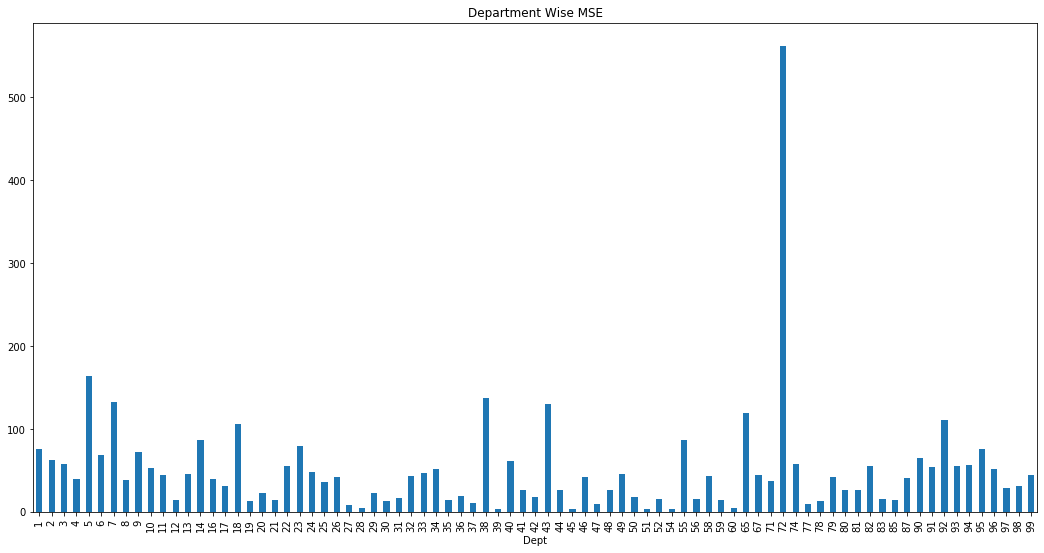

In [51]:
fig = plt.figure(figsize=(18,9))
train_data_red.groupby(['Dept']).apply(lambda x: error(x['preds'],x['Weekly_Sales'],x['IsHoliday_bin'])).plot(kind='bar');
plt.title('Department Wise MSE');

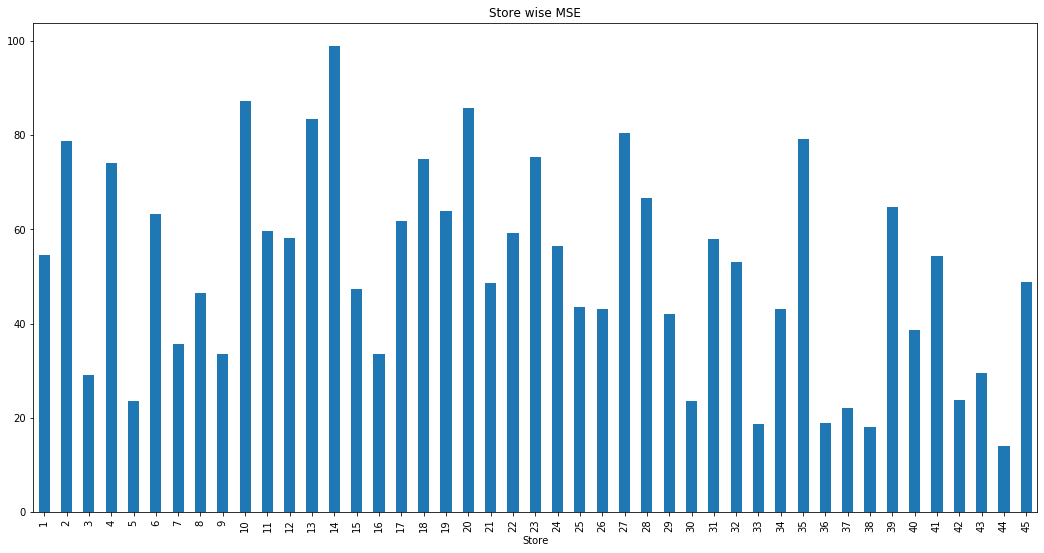

In [52]:
fig = plt.figure(figsize=(18,9))
train_data_red.groupby(['Store']).apply(lambda x: error(x['preds'],x['Weekly_Sales'],x['IsHoliday_bin'])).plot(kind='bar');
plt.title('Store wise MSE');

In [53]:
train_errors = pd.DataFrame(train_data_red.groupby(['Dept','Store']).apply(lambda x: error(x['preds'],x['Weekly_Sales'],x['IsHoliday_bin'])),columns=['WMSE'])

In [54]:
error_mat = train_errors.unstack()

In [55]:
error_mat.columns = range(1,46)

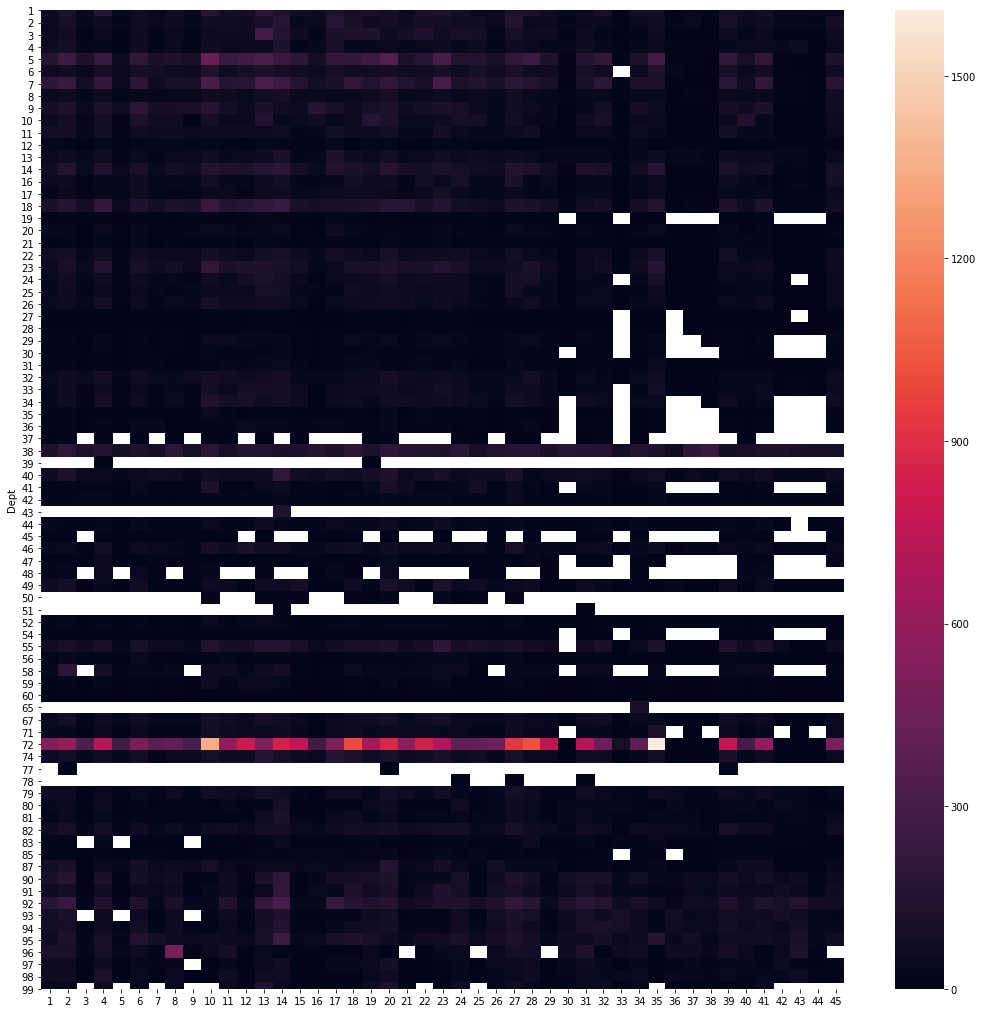

In [56]:
fig = plt.figure(figsize=(18,18))
hm = sns.heatmap(error_mat)